# Композиции алгоритмов

Одно дерево дает нестабильные результаты при разных разбиениях данных. Решение:

1. Обучим много алгоритмов
2. Усредним ответы

<div align="center"><img width="100" src="https://s3.amazonaws.com/media-p.slid.es/uploads/752784/images/5557074/pasted-from-clipboard.png"></div>

Но как добиться от алгоритмов разных ответов?

## Бутстреп выборки

<div align="center"><img width="700" src="images/4.png"></div>

- выбираем из обучающей выборки $l$ объектов с возвратом
- можно также выбирать случайные подпространства признаков

Теперь мы можем более объективно рассматривать статистики выборок. И здесь вступает в игру центральная предельная теорема.

## Центральная предельная теорема

- Имеем n распределений величины
- Величина распределена по одному и тому же закону $y \sim F(X)$ с математическим ожиданием $\mathbb{E}y$ и дисперсией $\sigma^2 $
- Сформируем новое распределение из выборочных средних: $\overline{y}_n = \frac{1}{n}\sum\limits_{i=1}^{n}y_i $
- Математическое ожидание нового распределения: $\mathbb{E}y$
- Дисперсия нового распределения: $\frac{\sigma^2}{n} $

## Бэггинг

<div align="center"><img width="700" src="images/5.png"></div>

## Составляющие ошибки

<div align="center"><img width="500" src="images/6.jpg"></div>

### $$ Q(a, X) = Bias(a, X) + Variance(a, X) + Noise $$

### $$ a(X_i) = \mathbb{E}a(X_i)+ const + \sigma + Noise = y_i + const + \sigma + Noise $$

# Случайный лес

Для $n = 1, ..., N$:

1. Сгенерировать выборку $\widetilde X$ с помощью бутстрапа и метода случайных подпространств 
2. Построить решающее дерево $b_n(x)$ по выборке $\widetilde X$
3. Дерево строится, пока в каждом листе не окажется не более $n_{min}$ объектов

Тогда ответ для задачи **регрессии** будет равен среднему из ответов каждого из деревьев:

### $$ a(x) = \frac{1}{N}\sum\limits_{n=1}^Nb_n(x) $$

А для задачи **классификации** это будет самый часто встречающийся среди ответов деревьев класс:

### $$ a(x) = sign\frac{1}{N}\sum\limits_{n=1}{N}b_n(x) $$

<div align="center"><img width="700" src="images/7.jpg"></div>

#### Гиперпараметры случайного леса:

- количество деревьев
- глубина построения деревьев / количество листовых вершин в деревьях
- количество признаков, по которым вычисляется энтропия
- и другие

## Сравнение случайного леса и дерева

### 1. Для задачи регрессии

Посмотрим на то, как дерево и лес приближают синус. Сгенерируем синус - функцию, которая довольно тяжко аппроксимируется деревянными методами.

In [1]:
import numpy as np
import pandas as pd
import pylab as plt

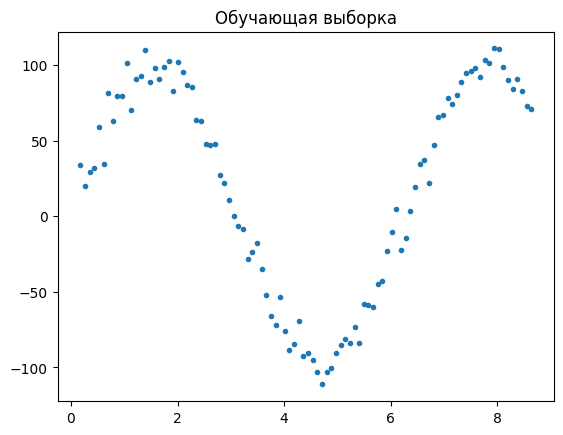

In [2]:
# генерация обучающей выборки
x_train = np.array([i * np.pi / 180 for i in range(10, 500, 5)])
np.random.seed(1)
y_train = 100 * np.sin(x_train) + np.random.normal(0, 10, len(x_train))
data_train = pd.DataFrame(np.column_stack([x_train, y_train]), columns=['x', 'y'])
plt.plot(data_train['x'], data_train['y'], '.')
plt.title("Обучающая выборка")

# генерация тестовой выборки
x_test = np.array([i * np.pi / 180 for i in range(0, 550, 1)])
np.random.seed(1)
y_test = 100 * np.sin(x_test) + np.random.normal(0, 10, len(x_test))
data_test = pd.DataFrame(np.column_stack([x_test, y_test]), columns=['x', 'y'])

А теперь обучим 3 модели:

- дерево
- бэггинг на деревьях
- случайный лес

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

tree_predictions = DecisionTreeRegressor(max_depth=5).fit(data_test[["x"]], data_test["y"]).predict(data_test[["x"]])
bagging_predictions = BaggingRegressor(DecisionTreeRegressor(max_depth=5)).fit(data_test[["x"]], data_test["y"]).predict(data_test[["x"]])
forest_predictions = RandomForestRegressor(max_depth=5).fit(data_test[["x"]], data_test["y"]).predict(data_test[["x"]])

Построим графики, какие предсказания выдали наши модели на тестовой выборке:

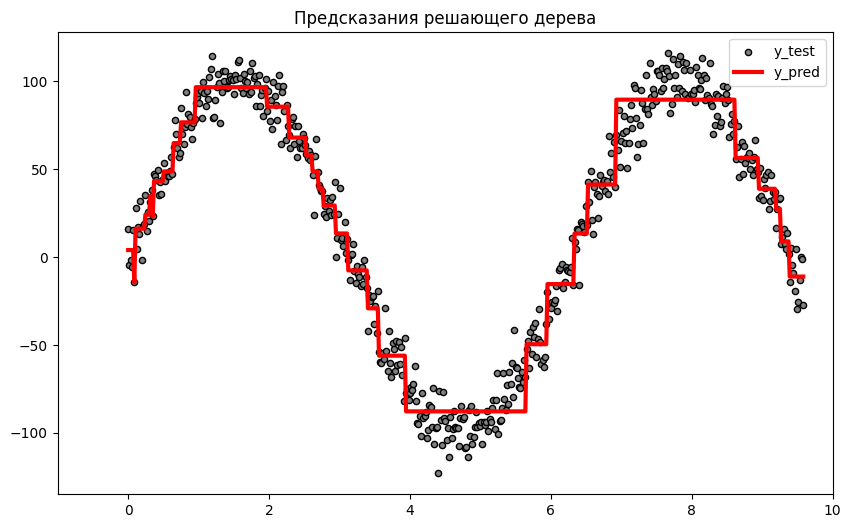

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, c="gray", s=20, edgecolors="black")
plt.plot(x_test, tree_predictions, "red", lw=3)
plt.xlim([-1, 10])
plt.legend(["y_test", "y_pred"])
plt.title("Предсказания решающего дерева")
plt.show()

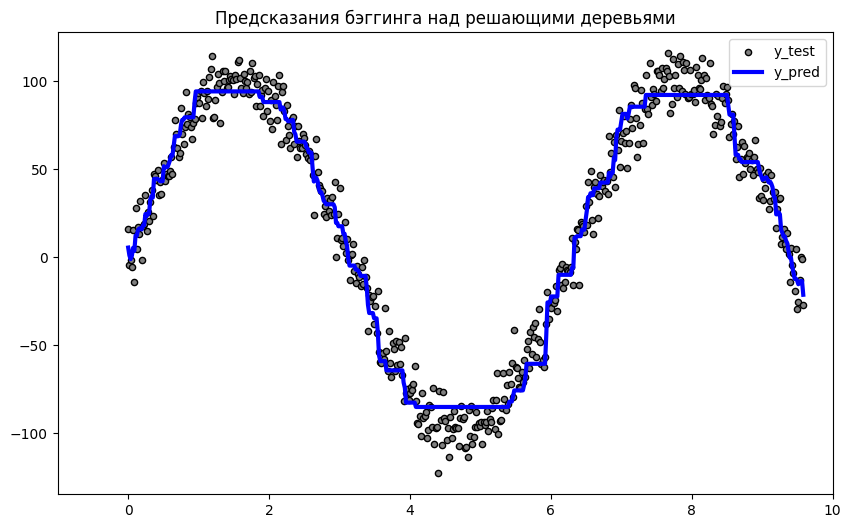

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, c="gray", s=20, edgecolors="black")
plt.plot(x_test, bagging_predictions, "blue", lw=3)
plt.xlim([-1, 10])
plt.legend(["y_test", "y_pred"])
plt.title("Предсказания бэггинга над решающими деревьями")
plt.show()

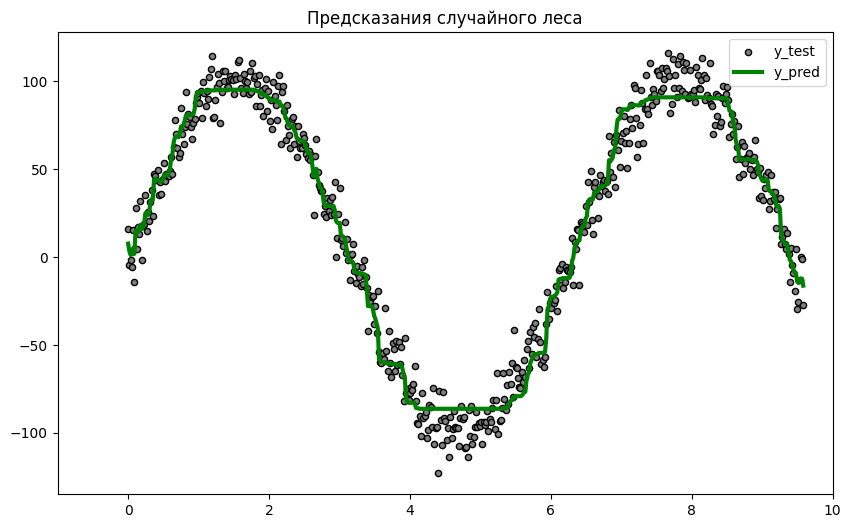

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, c="gray", s=20, edgecolors="black")
plt.plot(x_test, forest_predictions, "green", lw=3)
plt.xlim([-1, 10])
plt.legend(["y_test", "y_pred"])
plt.title("Предсказания случайного леса")
plt.show()

# Классификация

Посмотрим, какую разделяющую поверхность построят дерево решений, бэггинг и случайный лес для случая, когда один из классов находится как бы внутри другого.

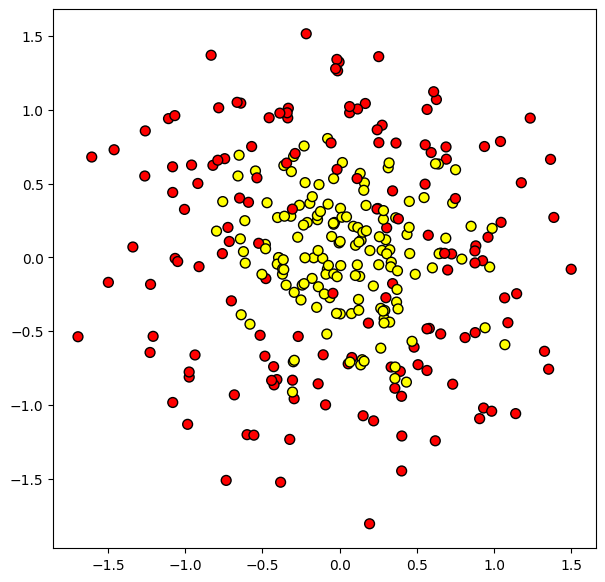

In [7]:
from sklearn.datasets import make_circles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# генерация данных: два класса, расположенных один в другом
X, y = make_circles(n_samples=300, factor=0.1, noise=0.35, random_state=42)
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn", edgecolors='black')

In [8]:
# напишем функцию для визуализации границы принятия решений
def plot_decision_boundary(model, X, y):
    fig, ax = plt.subplots()
    x0_min, x0_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    x1_min, x1_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    x0, x1 = np.meshgrid(np.linspace(x0_min, x0_max, 300), np.linspace(x1_min, x1_max, 300))
    border_predictions = model.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
    ax.contourf(x0, x1, border_predictions, alpha=0.1, cmap=plt.cm.autumn)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.autumn, edgecolor='k')
    ax.set_title(f"{model.__class__.__name__}: граница принятия решений")
    fig.set_size_inches((7, 7))

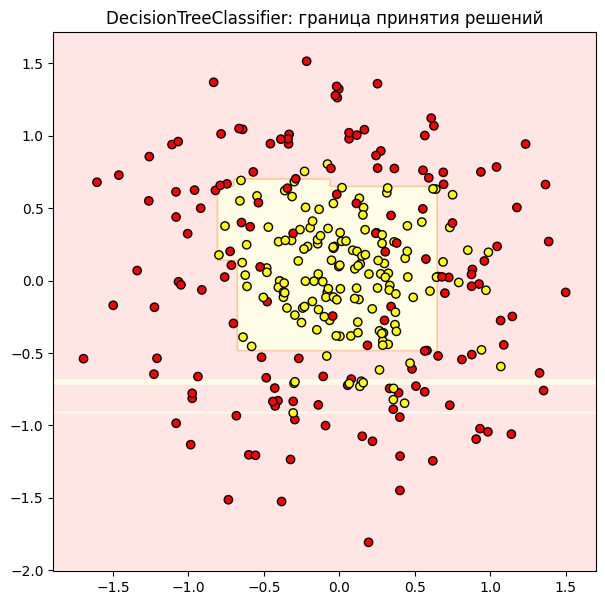

<Figure size 700x700 with 0 Axes>

In [9]:
tree = DecisionTreeClassifier(max_depth=5).fit(X, y)
plot_decision_boundary(tree, X, y)
plt.figure(figsize=(7, 7))
plt.show()

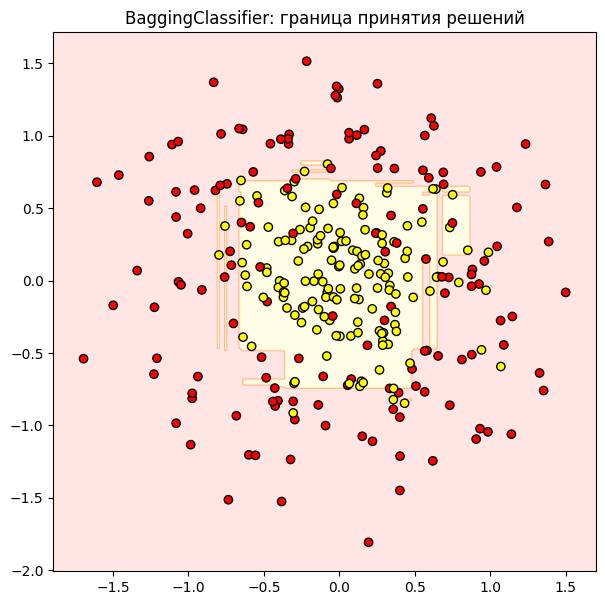

In [10]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=5)).fit(X, y)
plot_decision_boundary(bagging, X, y)
plt.show()

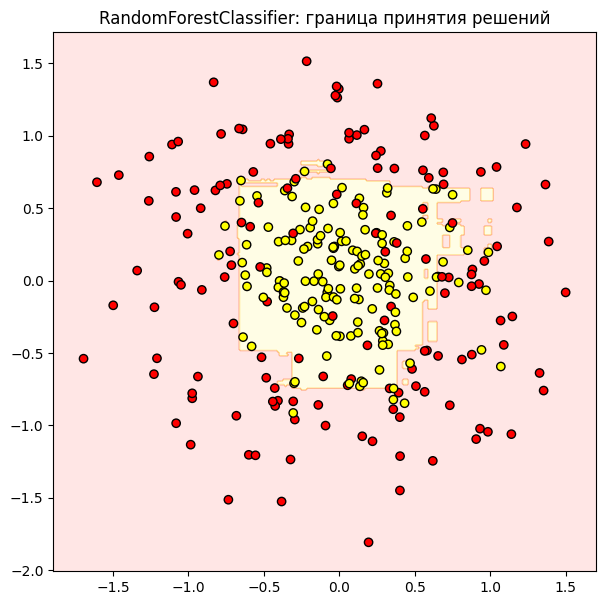

In [11]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5).fit(X, y)
plot_decision_boundary(forest, X, y)
plt.show()